# Customer churn

Customers began to leave Bank "N". Every month. By a little, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

We need to predict whether the client will leave the bank in the near future or not. We have been provided with historical data on customer behavior and termination of agreements with the bank.

We're going to use F1 as an estimator. To call the model successful we need to get at least 0.59 on a test sample.

## Introduction

We are faced with the task of predicting the outflow of customers from the bank. We have been provided with a file containing data on the behavior of customers and the fact of their termination or no agreement with the bank. We will study the available data, if necessary, we will do preprocessing and create a model that will help predict the client's churn.

## Data preparation

**Importing of necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

**Reading of the files**

In [2]:
data = pd.read_csv('Churn.csv')

**Basic information about the dataframe**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


0    0.7963
1    0.2037
Name: Exited, dtype: float64


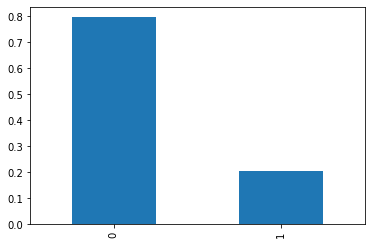

In [5]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

The data contains 10000 strings (customers). There are 14 columns. One column, `Tenure` has missed data, we'll take a look at it. The `Exited` column is the target, checked for imbalance, the data in it is not balanced 80/20. 80% are not lost customers.

**Missed data**

In [6]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
data['Tenure'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [8]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

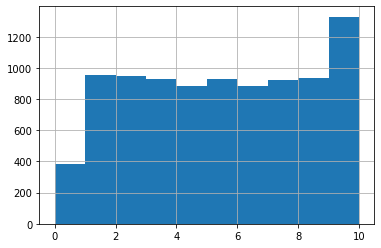

In [9]:
data['Tenure'].hist();

There are 909 gaps in the `Tenure` column. The column contains integer values from 0 to 10. In the range 2-9, the number of values is approximately the same, about 900 rows. 0 and 10 have fewer values, 382 and 446 respectively.

This column shows how many years the user has been a client of the bank. We can assume that the missing values are 0 years, but if our assumption is not correct, then by doing this we will distort the original data for the model. We can either leave gaps or remove them, this is about 9% of the original amount. We will remove the gaps, 9% is certainly not small, but not critical either.

In [10]:
data = data.dropna(subset=['Tenure']).reset_index(drop=True)

In [11]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

**Removing unnecessary data**

We don't need columns `RowNumber`, `CustomerId`, `Surname`, we'll remove it.

In [12]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1).reset_index(drop=True)

**Splitting data into samples**

The target contains the `Exited` column as two values (0 - the client has not left and 1 - the client has left). All other columns will be used as features.

We are faced with the task of classification, the data contains both categorical features and numerical. With the help of One Hot Encoding (**OHE**) we will transform all categorical into numerical ones.

In [13]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [14]:
data_ohe.shape

(9091, 12)

In [15]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


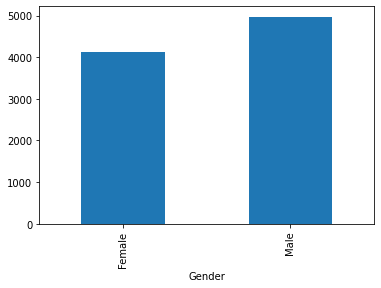

In [16]:
data.groupby('Gender')['Gender'].agg('count').plot(kind='bar');

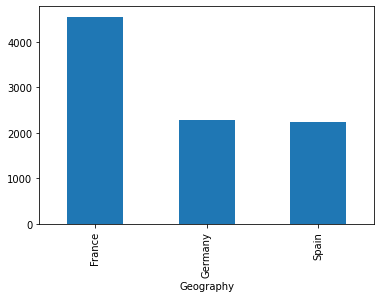

In [17]:
data.groupby('Geography')['Geography'].agg('count').plot(kind='bar');

Instead of a column with the country of residence, we got two (Germany and Spain) in which the information about the country of residence is contained in binary form, if both columns are 0, then the country of residence is France.

Now we have 12 columns, all features have become numerical.

In [18]:
features = data_ohe.drop('Exited', axis=1,)
target = data_ohe['Exited']

From the available data, we need to get three samples:

- Training: for training the model.
- Validation: with which we will check the model during the selection of hyperparameters.
- Test: on which we will test the selected finished model.

The division will be made in the ratio 3:1:1, 60% - training sample and 20% validation and test samples.

In [19]:
features_train, features_rest, target_train, target_rest = train_test_split(
    features, target, train_size=0.6, random_state=12345, stratify=target)

In [20]:
print(features_train.shape)
print(features_rest.shape)
print(target_train.shape)
print(target_rest.shape)

(5454, 11)
(3637, 11)
(5454,)
(3637,)


In [21]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_rest, target_rest, test_size=0.5, random_state=12345, stratify=target_rest)

In [22]:
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(1818, 11)
(1819, 11)
(1818,)
(1819,)


In [23]:
features_train_val = pd.concat([features_train, features_valid])
target_train_val = pd.concat([target_train, target_valid])

In [24]:
print(features_train_val.shape)
print(target_train_val.shape)

(7272, 11)
(7272,)


Made a split, checked the dimensions - everything is correct. We got three samples, and also collected the fourth one by combining the training and validation samples. This sample is useful for selecting parameters using cross-validation

**Standartization**

Let's make standartization of the features to equalize their weight in the process of training the model.

In [25]:
numeric = ['CreditScore',
           'Age',
           'Tenure',
           'Balance',
           'NumOfProducts',
           'HasCrCard',
           'IsActiveMember',
           'EstimatedSalary',
          ]

In [26]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train_val[numeric] = scaler.transform(features_train_val[numeric])

### Data preparation conclusions

We studied the received data.
- We found gaps in the data, we had to get rid of them because of the inability to correctly restore them.
- There is an imbalance of the target in the data - 80%/20%. In the future, we will create models both taking into account this imbalance and not.
- Removed unnecessary columns for training a model - `RowNumber`, `CustomerId`, `Surname`.
- Converted all categorical features to numerical ones using One Hot Encoding (OHE).
- Divided the data into samples in the ratio 3:1:1 (60%/20%/20%):
 - Training - for training the model (60%).
 - Validation - to test the model during training and help in choosing hyperparameters (20%).
 - Test - on which we will test our finished model (20%).
 - We also made a sample for the selection and training of the model using cross-validation, for this technique a separate validation sample is not needed, so we combined the training and validation samples.
- Made standartization of features to equalize their weight.

## Models research

Prepared data for the model. For now, the imbalance of the target has been ignored. Let's see what results we can achieve in this way, and then work on balancing.

### "Dummy" model

First, let's look at a dummy model that will ignore incoming features, instead, the prediction will be made randomly. We'll specify 'the strategy' hyperparameter as 'most_frequent', now the model will always give as an answer the most frequently encountered target in the learning process.

In [27]:
dummy = DummyClassifier(random_state=12345, strategy="most_frequent")
dummy.fit(features_train, target_train)
dummy_predicted_train = dummy.predict(features_train)
dummy_predicted_valid = dummy.predict(features_valid)

print('Training sample:', dummy.score(features_train, target_train))
print('Validation sample:', dummy.score(features_valid, target_valid))
print('F1:', f1_score(target_valid, dummy_predicted_valid))
print('Confusion matrix:')
print(confusion_matrix(target_valid, dummy_predicted_valid))

Training sample: 0.7961129446277961
Validation sample: 0.7959295929592959
F1: 0.0
Confusion matrix:
[[1447    0]
 [ 371    0]]


This model showed an accuracy of 0.80 which is expected due to data imbalance.

### Logistic Regression

Let's see what results the logistic regression will show.

Accuracy on validation sample: 0.7095709570957096
F1 on validation sample: 0.5065420560747663 

Confusion matrix:
[[1019  428]
 [ 100  271]]


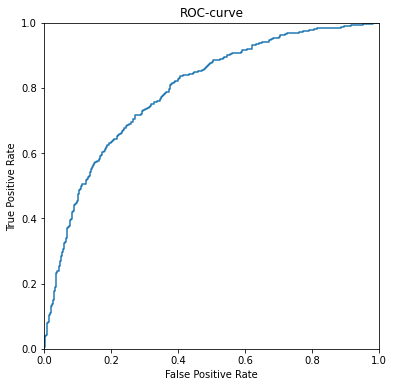

AUC-ROC on validation sample: 0.7907260490614472


In [28]:
logreg_model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
logreg_model.fit(features_train, target_train)
logreg_predicted_valid = logreg_model.predict(features_valid)

probabilities_valid = logreg_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print('Accuracy on validation sample:', logreg_model.score(features_valid, target_valid))
print('F1 on validation sample:', f1_score(target_valid, logreg_predicted_valid), '\n')
print('Confusion matrix:' )
print(confusion_matrix(target_valid, logreg_predicted_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on validation sample:', auc_roc_valid)

Logistic regression on the unbalanced validation sample showed the following results:

- F1: **0.507**
- AUC-ROC: **0.791**

These results do not suit us, let's move on to the decision tree.

### Decision tree

Let's select the best parameters for the decision tree using cycles.

The best model: DecisionTreeClassifier(max_depth=9, max_leaf_nodes=46, min_samples_leaf=10,
                       random_state=12345) 

F1 of the best model on validation sample: 0.6094946401225114 

Confusion matrix:
[[1373   74]
 [ 207  164]]


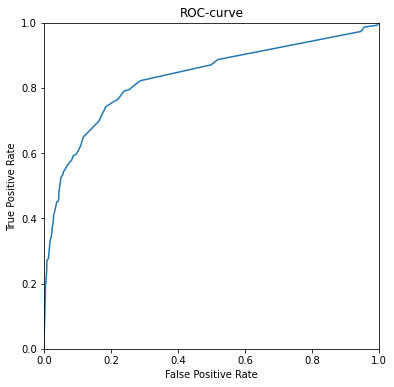

AUC-ROC on validation sample: 0.8306348109388882
CPU times: total: 6min 18s
Wall time: 6min 18s


In [29]:
%%time

weights = ['balanced', None]

dt_model = None
dt_result = 0
for depth in range(1, 21):
    for leafs in range(2, 51):
        for samp_leafs in range(1, 21):
            for weight in weights:
                model = DecisionTreeClassifier(random_state=12345,
                                               class_weight=weight,
                                               max_depth=depth,
                                               max_leaf_nodes=leafs,
                                               min_samples_leaf=samp_leafs)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                result = f1_score(target_valid, predictions_valid)
                if result > dt_result:
                    dt_model = model
                    dt_result = result

probabilities_valid = dt_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("The best model:", dt_model, '\n')
print("F1 of the best model on validation sample:", dt_result, '\n')
print('Confusion matrix:')
print(confusion_matrix(target_valid, predictions_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on validation sample:', auc_roc_valid)

Decision tree with the following parameters: max_depth=9, max_leaf_nodes=46, min_samples_leaf=10, random_state=12345) on the unbalanced validation sample showed the following results:

- F1: **0.609**
- AUC-ROC: **0.831**

The results are already better than the logistic regression. Let's move on to the random forest.

### Random forest

Let's select the best parameters for a random forest using cycles.

The best model: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=230,
                       random_state=12345)

F1 of the best model on validation sample: 0.6555697823303457

Confusion matrix:
[[1394   53]
 [ 191  180]]


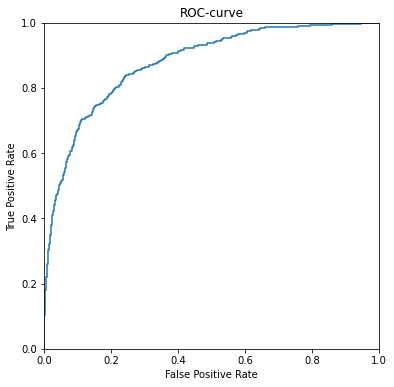

AUC-ROC on validation sample: 0.8770259874039978
CPU times: total: 6min 41s
Wall time: 6min 41s


In [30]:
%%time

weights = ['balanced', None]

rf_model = None
rf_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 41, 2):
        for weight in weights:
            model = RandomForestClassifier(random_state=12345,
                                           class_weight=weight,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > rf_result:
                rf_model = model
                rf_result = result

probabilities_valid = rf_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("The best model:", rf_model)
print('')
print("F1 of the best model on validation sample:", rf_result)
print('')
print('Confusion matrix:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on validation sample:', auc_roc_valid)

Random forest with the following parameters: (class_weight='balanced', max_depth=9, n_estimators=230, random_state=12345) on the unbalanced validation sample showed the following results:

- F1: **0.656**
- AUC-ROC: **0.877**

The results are much better than logistic regression and decision tree. We will use a random forest.

### Cross-validation

Let's try to find hyperparameters for a random forest using GridSearchCV cross-validation.

In [31]:
n_estimators = []
max_depth = []


for est in range(100, 251, 10):
    n_estimators.append(est)
for depth in range(1, 21, 2):
    max_depth.append(depth)

In [32]:
rf = RandomForestClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'n_estimators': n_estimators,
    'max_depth': max_depth
         }

rf_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [33]:
%%time
rf_clf.fit(features_train_val, target_train_val)

CPU times: total: 15min 9s
Wall time: 15min 9s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [34]:
print(rf_clf.best_estimator_)
print("F1 of the model:", rf_clf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=230,
                       random_state=12345)
F1 of the model: 0.6288849304871543


With the help of cross-validation, we obtained the same parameters as in the case of iterating in cycles. Ranom forest (class_weight='balanced', max_depth=9, n_estimators=230, random_state=12345).

### Model research conclusions

The following models were tested on unbalanced data: Logistic Regression, Decision Tree, Random Forest. Random forest showed the best result. We also used cross-validation on a random forest and got similar results as without it.

The best result on the validation sample at the moment: **F1 - 0.656, AUC-ROC: 0.877**. Let's try to work on balancing in order to improve the result.

## Dealing with imbalance

Let's try several balancing methods, upsampling and downsampling.

### Upsampling

With this method, we will increase the number of class in the sample that is underrepresented (1). Let's write the upsample function.

In [35]:
def upsample(features, target, repeat): # As arguments, the function will take: features, target and how many times to multiply 1 class
    features_zeros = features[target == 0] # We'll mark features of class 0
    features_ones = features[target == 1] # We'll mark features of class 1
    target_zeros = target[target == 0] # We'll mark target of class 0
    target_ones = target[target == 1] # We'll mark target of class 1

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) # We multiply the features of class 1 and connect both classes
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) # We multiply the target of class 1 and connect both classes
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345) # Shuffle the data
    
    return features_upsampled, target_upsampled

Let's apply the function for the test sample and look at the class balance.

In [36]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

In [37]:
features_train_val_upsampled, target_train_val_upsampled = upsample(features_train_val, target_train_val, 4)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

Now both classes are represented equally.

On the upsampled test sample, we'll select the parameters for the random forest.

The best model: RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=200,
                       random_state=12345)

F1 of the best model on validation sample: 0.6463104325699747

Confusion matrix:
[[1345  102]
 [ 154  217]]


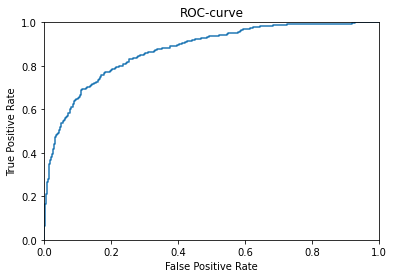

AUC-ROC on validation sample: 0.8727639860888874
CPU times: total: 9min 39s
Wall time: 9min 39s


In [38]:
%%time

weights = ['balanced', None]

rf_upsampled_model = None
rf_upsampled_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 41, 2):
        for weight in weights:
                model = RandomForestClassifier(random_state=12345,
                                               class_weight=weight,
                                               n_estimators=est,
                                               max_depth=depth,)
                model.fit(features_upsampled, target_upsampled)
                predicted_valid = model.predict(features_valid)
                result = f1_score(target_valid, predicted_valid)
                if result > rf_upsampled_result:
                    rf_upsampled_model = model
                    rf_upsampled_result = result

probabilities_valid = rf_upsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("The best model:", rf_upsampled_model)
print('')
print("F1 of the best model on validation sample:", rf_upsampled_result)
print('')
print('Confusion matrix:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on validation sample:', auc_roc_valid)

On a balanced by increasing the sample, it was not possible to achieve an improvement in the results on the validation sample.

The model with the following parameters has the best result: (class_weight='balanced', max_depth=11, n_estimators=200, random_state=12345)

- F1: **0.646**
- AUC-ROC: **0.873**

Now let's try to select parameters using GridSearchCV.

In [39]:
rf_upsampled_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [40]:
%%time
rf_upsampled_clf.fit(features_train_val_upsampled, target_train_val_upsampled)

CPU times: total: 22min 15s
Wall time: 22min 16s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [41]:
print(rf_upsampled_clf.best_estimator_)
print("F1 of the model:", rf_upsampled_clf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=120,
                       random_state=12345)
F1 of the model: 0.9576759251596025


On a balanced by increasing the sample, cross-validation managed to find hyperparameters on which we get the result **F1 - 0.958**

### Downsampling

We'll try to decrease the more represented class (0) in the sample. Let's write the downsample function.

In [42]:
def downsample(features, target, fraction): # As arguments, the function will take: features, target, and what percentage of class 0 to leave
    features_zeros = features[target == 0] # # We'll mark features of class 0
    features_ones = features[target == 1] # We'll mark features of class 1
    target_zeros = target[target == 0] # We'll mark target of class 0
    target_ones = target[target == 1] # We'll mark target of class 1

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]) # Using the pandas .sample method, we leave only the specified fraction of class 0, after that we connect both classes 
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]) # Using the pandas .sample method, we leave only the specified fraction of class 0, after that we connect both classes
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345) # Shuffle the data
    
    return features_downsampled, target_downsampled

Let's apply the function for the test sample and look at the class balance.

In [43]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.257)
target_downsampled.value_counts(normalize=True)

0    0.500898
1    0.499102
Name: Exited, dtype: float64

In [44]:
features_train_val_downsampled, target_train_val_downsampled = downsample(features_train_val, target_train_val, 0.257)
target_upsampled.value_counts(normalize=True)

1    0.50603
0    0.49397
Name: Exited, dtype: float64

Now both classes are represented equally.

On a downsampled test sample, we'll select parameters for a random forest.

The best model: RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=160,
                       random_state=12345)

F1 of the best model on validation sample: 0.623541887592789

Confusion matrix:
[[1143  304]
 [  77  294]]


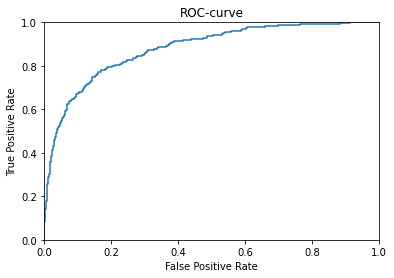

AUC-ROC on validation sample: 0.8786186496087267
CPU times: total: 2min 37s
Wall time: 2min 37s


In [45]:
%%time

weights = ['balanced', None]

rf_downsampled_model = None
rf_downsampled_result = 0
for est in range(100, 251, 10):
    for depth in range(1, 31, 2):
         for weight in weights:
            model = RandomForestClassifier(random_state=12345,
                                           class_weight=weight,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_downsampled, target_downsampled)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > rf_downsampled_result:
                rf_downsampled_model = model
                rf_downsampled_result = result

probabilities_valid = rf_downsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_valid = roc_auc_score(target_valid, probabilities_one_valid)

print("The best model:", rf_downsampled_model)
print('')
print("F1 of the best model on validation sample:", rf_downsampled_result)
print('')
print('Confusion matrix:')
print(confusion_matrix(target_valid, predicted_valid))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on validation sample:', auc_roc_valid)

On balanced sample by reduction, the sample failed to achieve an improvement in the results on the validation set.

The model with the following parameters has the best result:  (class_weight='balanced', max_depth=13, n_estimators=160, random_state=12345)

- F1: **0.624**
- AUC-ROC: **0.879**

Now let's try to select parameters using GridSearchCV.

In [46]:
rf_downsampled_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='f1'
)

In [47]:
%%time
rf_downsampled_clf.fit(features_train_val_downsampled, target_train_val_downsampled)

CPU times: total: 8min 3s
Wall time: 8min 3s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250],
                         'random_state': [12345]},
             scoring='f1')

In [48]:
print(rf_downsampled_clf.best_estimator_)
print("F1 of the model:", rf_downsampled_clf.best_score_)

RandomForestClassifier(max_depth=11, n_estimators=110, random_state=12345)
F1 of the model: 0.7798260533363631


On a balanced by reducing the sample, cross-validation managed to find hyperparameters on which we get the result **F1 - 0.780**

### Balancing conclusion

We tried to balance the sample using two methods: increasing the under-represented class (upsampling) and decreasing the more-represented class (downsampling).

It was possible to achieve an improvement only when selecting hyperparameters using cross-validation.
The best result on the test data was obtained using upsampling and GridSearchCV. **F1 - 0.958**

### Changing the Classification Threshold

Let's see if we can improve the results on the trained random forest models by changing the classification threshold.

In [49]:
probabilities_valid = rf_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Threshold = {:.2f} | Accuracy = {:.3f}, Recall = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.02 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.04 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.06 | Accuracy = 0.206, Recall = 1.000, F1 = 0.341
Threshold = 0.08 | Accuracy = 0.215, Recall = 0.997, F1 = 0.354
Threshold = 0.10 | Accuracy = 0.228, Recall = 0.992, F1 = 0.371
Threshold = 0.12 | Accuracy = 0.244, Recall = 0.989, F1 = 0.391
Threshold = 0.14 | Accuracy = 0.258, Recall = 0.987, F1 = 0.409
Threshold = 0.16 | Accuracy = 0.273, Recall = 0.987, F1 = 0.428
Threshold = 0.18 | Accuracy = 0.285, Recall = 0.978, F1 = 0.442
Threshold = 0.20 | Accuracy = 0.299, Recall = 0.962, F1 = 0.456
Threshold = 0.22 | Accuracy = 0.313, Recall = 0.949, F1 = 0.471
Threshold = 0.24 | Accuracy = 0.330, Recall = 0.930, F1 = 0.487
Threshold = 0.26 | Accuracy = 0.349, Recall = 0.922, F1 = 0.506
Threshold = 0.28 | Accuracy = 0.371, Recall = 0.908, F1 = 0.527
Threshold = 0.30 | Accuracy = 0.393, Rec

On a model with an imbalance, the standard threshold of 0.5 shows the best results, **F1 - 0.656**

In [50]:
probabilities_valid = rf_upsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Threshold = {:.2f} | Accuracy = {:.3f}, Recall = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.02 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.04 | Accuracy = 0.207, Recall = 1.000, F1 = 0.343
Threshold = 0.06 | Accuracy = 0.220, Recall = 0.995, F1 = 0.360
Threshold = 0.08 | Accuracy = 0.233, Recall = 0.995, F1 = 0.377
Threshold = 0.10 | Accuracy = 0.247, Recall = 0.992, F1 = 0.396
Threshold = 0.12 | Accuracy = 0.264, Recall = 0.989, F1 = 0.417
Threshold = 0.14 | Accuracy = 0.275, Recall = 0.981, F1 = 0.429
Threshold = 0.16 | Accuracy = 0.288, Recall = 0.970, F1 = 0.444
Threshold = 0.18 | Accuracy = 0.297, Recall = 0.951, F1 = 0.452
Threshold = 0.20 | Accuracy = 0.309, Recall = 0.943, F1 = 0.466
Threshold = 0.22 | Accuracy = 0.327, Recall = 0.935, F1 = 0.484
Threshold = 0.24 | Accuracy = 0.342, Recall = 0.925, F1 = 0.499
Threshold = 0.26 | Accuracy = 0.363, Recall = 0.900, F1 = 0.517
Threshold = 0.28 | Accuracy = 0.387, Recall = 0.881, F1 = 0.537
Threshold = 0.30 | Accuracy = 0.404, Rec

On a larger sample, the best result is also with a standard threshold of 0.5, **F1 - 0.646**

In [51]:
probabilities_valid = rf_downsampled_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)

    print("Threshold = {:.2f} | Accuracy = {:.3f}, Recall = {:.3f}, F1 = {:.3f}".format(
        threshold, precision, recall, f1))

Threshold = 0.00 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.02 | Accuracy = 0.204, Recall = 1.000, F1 = 0.339
Threshold = 0.04 | Accuracy = 0.207, Recall = 1.000, F1 = 0.344
Threshold = 0.06 | Accuracy = 0.215, Recall = 1.000, F1 = 0.354
Threshold = 0.08 | Accuracy = 0.223, Recall = 0.997, F1 = 0.365
Threshold = 0.10 | Accuracy = 0.230, Recall = 0.992, F1 = 0.374
Threshold = 0.12 | Accuracy = 0.240, Recall = 0.992, F1 = 0.386
Threshold = 0.14 | Accuracy = 0.250, Recall = 0.992, F1 = 0.399
Threshold = 0.16 | Accuracy = 0.258, Recall = 0.987, F1 = 0.408
Threshold = 0.18 | Accuracy = 0.265, Recall = 0.987, F1 = 0.418
Threshold = 0.20 | Accuracy = 0.273, Recall = 0.981, F1 = 0.427
Threshold = 0.22 | Accuracy = 0.283, Recall = 0.978, F1 = 0.439
Threshold = 0.24 | Accuracy = 0.293, Recall = 0.973, F1 = 0.450
Threshold = 0.26 | Accuracy = 0.305, Recall = 0.960, F1 = 0.463
Threshold = 0.28 | Accuracy = 0.316, Recall = 0.943, F1 = 0.473
Threshold = 0.30 | Accuracy = 0.328, Rec

On a reduced sample, the best result with a threshold of 0.66, **F1 - 0.659**

### Balancing conclusions (part 2)

The best model after balancing turned out to be Random Forest trained on data processed by sample increase and hyperparameters matched using cross-validation.

We also tested downsampling and changing the classification thresholds, these techniques did not give a significant improvement in results compared to an unbalanced sample.

## Model testing

We've chose the following model: ``RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=120, random_state=12345)`` trained with the help of GridSearchCV on 80% of the original data and balanced using the **upsamling** technique, we allocated the remaining 20% for the test sample, which we will now use.

Accuracy on test sample: 0.8521165475536009
F1 on test sample: 0.6072992700729928

Confusion matrix:
[[1342  106]
 [ 163  208]]


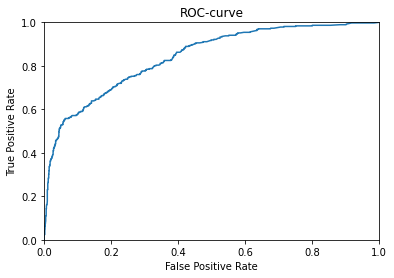

AUC-ROC on test sample: 0.8410327098628464


In [52]:
predicted_test = rf_upsampled_clf.predict(features_test)


probabilities_test = rf_upsampled_clf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print('Accuracy on test sample:', accuracy_score(target_test, predicted_test))
print('F1 on test sample:', f1_score(target_test, predicted_test))
print('')
print('Confusion matrix:')
print(confusion_matrix(target_test, predicted_test))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on test sample:', auc_roc_test)

On the test sample, the following results were obtained:

- F1:  **0.607**
- AUC-ROC: **0.841**
- Accuracy: **0.852**

Let's compare it with the "dummy" model.

Accuracy: 0.7960417811984607
F1: 0.0
Confusion matrix:
[[1448    0]
 [ 371    0]]


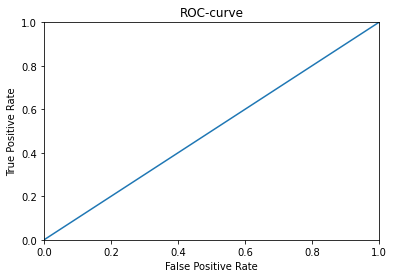

AUC-ROC on test sample: 0.5


In [53]:
dummy = DummyClassifier(random_state=12345, strategy="most_frequent")
dummy.fit(features_train, target_train)

dummy_predicted_test = dummy.predict(features_test)

probabilities_test = dummy.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

print('Accuracy:', dummy.score(features_test, target_test))
print('F1:', f1_score(target_test, dummy_predicted_test))
print('Confusion matrix:')
print(confusion_matrix(target_test, dummy_predicted_test))

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

print('AUC-ROC on test sample:', auc_roc_test)

The results obtained using the selected model on the test sample suit us.

## Conclusions

We were faced with the task of classifying with a known target. We examined the received data: processed it, removed unnecessary data, divided it into samples necessary for training and testing the model. In the course of the study, an imbalance of the target was found, and we checked how the models would learn without taking into account this imbalance.

The following models were tested: Logistic Regression, Decision Tree, Random Forest. During testing, we settled on using a random forest, the other models showed significantly worse results. The selection of optimal hyperparameters was approached in two ways: enumeration using cycles and cross-validation GridSearchCV. On unbalanced data, the results obtained by these two methods were similar.

After that, we started balancing. Tried balancing with two techniques: Upsampling and Downsampling. We also tried to change the classification threshold, but this method did not achieve the best results. We settled on a model trained on an upsampling sample using cross-validation. We managed to achieve the following results on the test sample:

- F1:  **0.607**
- AUC-ROC: **0.841**
- Accuracy: **0.852**

The model was checked for adequacy by comparing it with a "dummy" model that predicts only the most common feature in the model training process. Our model has been tested.

Our model can confidently correctly predict the termination of a customer's agreement with a bank.